In [2]:
!pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.9 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [11]:
import sys
sys.path.append("/ibkr")

import os
import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pytz


import passwords
from databaseClass import DB
from utils import generate_df_from_sql_file, generate_list_from_sql_file
from utils import DataProcessor
from utils import ModelBuilder
from utils import Predictor
pd.set_option('display.max_rows', None)


In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Restrict TensorFlow to only use the first GPU
    tf.config.set_visible_devices(gpus[0], 'GPU')

    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


2023-07-17 21:59:51.224612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-17 21:59:51.234741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-17 21:59:51.234836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Mon Jul 17 21:59:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   46C    P2   109W / 350W |   1445MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# !pip install scikit-learn

In [5]:
userName = passwords.userName
userPass = passwords.userPass
dataBaseName = passwords.dataBaseName
host = passwords.host

In [6]:
db = DB(userName=userName, userPass=userPass, dataBaseName=dataBaseName, host='ibkr_db', docker=True)

In [7]:
db.tables

['tickdata_jun29',
 'tickdata_jul6',
 'tickdata_jul10',
 'tickdata_jul14',
 'predictions',
 'tickdata_jul17',
 'account_summary',
 'portfolio',
 'positions',
 'tickdata_jul13']

In [1]:
input_sql_file='../sql_files/test.sql'
df = generate_df_from_sql_file(input_sql_file, db)

NameError: name 'generate_df_from_sql_file' is not defined

In [9]:
df.head(10)

ticktype    price  volume                  timestamp
0         1  4434.75       0 2023-06-29 22:44:07.806861
1         2  4435.00       0 2023-06-29 22:44:07.818198
2         4  4435.00       0 2023-06-29 22:44:07.824383
3         5     0.00       1 2023-06-29 22:44:07.829809
4         5     0.00       1 2023-06-29 22:44:07.838547
5         5     0.00      11 2023-06-29 22:44:10.894014
6         1  4435.00       0 2023-06-29 22:44:10.920193
7         2  4435.25       0 2023-06-29 22:44:10.926092
8         4  4435.25       0 2023-06-29 22:44:25.667186
9         5     0.00       1 2023-06-29 22:44:25.687053

In [9]:
input_sql_file='../sql_files/test.sql'
df = generate_df_from_sql_file(input_sql_file, db)

def main_build_model(df, look_ahead=5):
    
    df['timestamp'] = df['timestamp'].dt.tz_localize('UTC') #adding this to update to utc

    # Create a DataProcessor instance
    processor = DataProcessor(df) 
    # Process the df
    processor.process_df()
    
    # Scale and shift the data
    scaler, close_scaler = processor.scale_shift_data(look_ahead)
    # Create the X and y datasets
    X, y = processor.scaled_df, processor.shifted_df['Close']
    # Create train test split
    X_train, X_test, y_train, y_test = processor.create_train_test_split(X, y)   
    # Create final train and test datasets
    TIME_STEPS = 60
    X_train, y_train = processor.create_dataset(X_train, y=y_train, time_steps=TIME_STEPS, for_training=True, look_ahead=look_ahead)
    X_test, y_test = processor.create_dataset(X_test, y=y_test, time_steps=TIME_STEPS, for_training=True, look_ahead=look_ahead)

    # Number of features in the data
    n_features = X_train.shape[2]
    
    # Create a ModelBuilder instance and build the model
    builder = ModelBuilder(n_features, TIME_STEPS)
    # Train the model
    model, history = builder.train_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=64)
    # Save the model
    model_path = '../models/model.h5'
    builder.save_model(model_path)
    # Plot loss
    builder.plot_loss(history)

Epoch 1/50


2023-07-17 22:00:33.822290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-17 22:00:33.943142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-17 22:00:34.189810: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x20d29070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-17 22:00:34.189828: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-07-17 22:00:34.203914: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-17 22:00:34.313334: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pr

87/87 [==============================] - 3s 19ms/step - loss: 0.0026 - val_loss: 0.0302
Epoch 2/50
87/87 [==============================] - 2s 18ms/step - loss: 0.0033 - val_loss: 0.0233
Epoch 3/50
87/87 [==============================] - 2s 18ms/step - loss: 0.0022 - val_loss: 0.0164
Epoch 4/50
87/87 [==============================] - 2s 18ms/step - loss: 0.0014 - val_loss: 0.0116
Epoch 5/50
87/87 [==============================] - 2s 18ms/step - loss: 0.0014 - val_loss: 0.0070
Epoch 6/50
87/87 [==============================] - 2s 18ms/step - loss: 0.0011 - val_loss: 0.0067
Epoch 7/50
87/87 [==============================] - 2s 19ms/step - loss: 0.0012 - val_loss: 0.0055
Epoch 8/50
87/87 [==============================] - 2s 18ms/step - loss: 9.5709e-04 - val_loss: 0.0039
Epoch 9/50
87/87 [==============================] - 2s 18ms/step - loss: 0.0011 - val_loss: 0.0062
Epoch 10/50
87/87 [==============================] - 2s 18ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 11/50
87/8

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


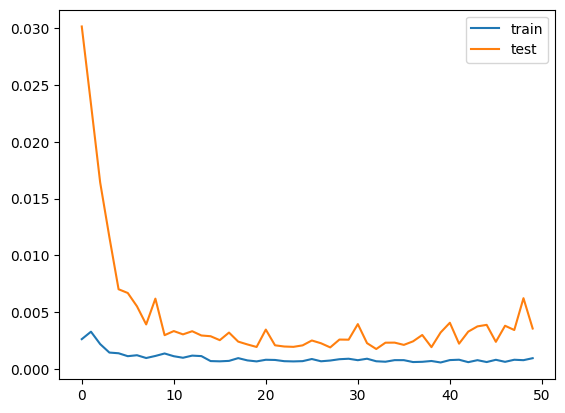

In [10]:
main_build_model(df, look_ahead=5)

In [10]:
def main_build_model_with_hps(df, best_hps, look_ahead=5):
    
    df['timestamp'] = df['timestamp'].dt.tz_localize('UTC') #adding this to update to utc

    # Create a DataProcessor instance
    processor = DataProcessor(df) 
    # Process the df
    processor.process_df()
    
    # Scale and shift the data
    scaler, close_scaler = processor.scale_shift_data(look_ahead)
    # Create the X and y datasets
    X, y = processor.scaled_df, processor.shifted_df['Close']
    # Create train test split
    X_train, X_test, y_train, y_test = processor.create_train_test_split(X, y)   
    # Create final train and test datasets
    TIME_STEPS = 60
    X_train, y_train = processor.create_dataset(X_train, y=y_train, time_steps=TIME_STEPS, for_training=True, look_ahead=look_ahead)
    X_test, y_test = processor.create_dataset(X_test, y=y_test, time_steps=TIME_STEPS, for_training=True, look_ahead=look_ahead)

    # Number of features in the data
    n_features = X_train.shape[2]
    
    # Create a ModelBuilder instance and build the model
    builder = ModelBuilder(n_features, TIME_STEPS)
    # Train the model
    model, history = builder.train_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=64, best_hps=best_hps)
    # Save the model
    model_path = '../models/model.h5'
    builder.save_model(model_path)
    # Plot loss
    builder.plot_loss(history)

/ibkr/databaseClass.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


Epoch 1/50
74/74 [==============================] - 2s 18ms/step - loss: 0.0129 - val_loss: 0.0052
Epoch 2/50
74/74 [==============================] - 1s 20ms/step - loss: 0.0102 - val_loss: 0.0457
Epoch 3/50
74/74 [==============================] - 1s 19ms/step - loss: 0.0121 - val_loss: 0.0919
Epoch 4/50
74/74 [==============================] - 1s 18ms/step - loss: 0.0107 - val_loss: 0.1458
Epoch 5/50
74/74 [==============================] - 1s 19ms/step - loss: 0.0123 - val_loss: 0.2173
Epoch 6/50
74/74 [==============================] - 1s 19ms/step - loss: 0.0151 - val_loss: 0.2436
Epoch 7/50
74/74 [==============================] - 1s 19ms/step - loss: 0.0181 - val_loss: 0.1834
Epoch 8/50
74/74 [==============================] - 1s 19ms/step - loss: 0.0137 - val_loss: 0.1764
Epoch 9/50
74/74 [==============================] - 1s 19ms/step - loss: 0.0133 - val_loss: 0.1775
Epoch 10/50
74/74 [==============================] - 1s 20ms/step - loss: 0.0126 - val_loss: 0.2112
Epoch 11/

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


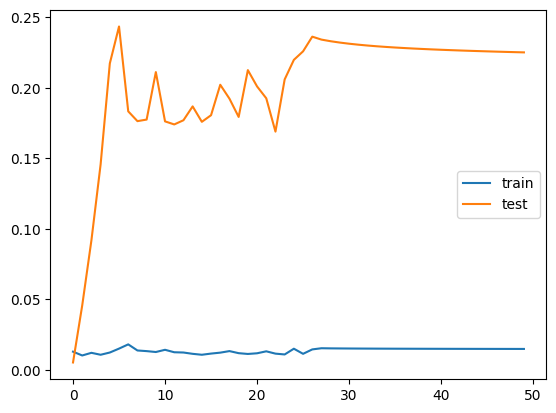

In [25]:
input_sql_file='../sql_files/test.sql'
df = generate_df_from_sql_file(input_sql_file, db)
main_build_model_with_hps(df, best_hps, look_ahead=5)

/ibkr/databaseClass.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


Epoch 1/50


2023-07-06 21:41:41.287196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-06 21:41:41.354172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-06 21:41:41.461840: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x630ba6f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-06 21:41:41.461855: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-07-06 21:41:41.464497: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-06 21:41:41.519840: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pr

74/74 [==============================] - 3s 19ms/step - loss: 0.0134 - val_loss: 0.0129
Epoch 2/50
74/74 [==============================] - 1s 18ms/step - loss: 0.0081 - val_loss: 0.0333
Epoch 3/50
74/74 [==============================] - 1s 18ms/step - loss: 0.0068 - val_loss: 0.0452
Epoch 4/50
74/74 [==============================] - 1s 18ms/step - loss: 0.0071 - val_loss: 0.0618
Epoch 5/50
74/74 [==============================] - 1s 18ms/step - loss: 0.0070 - val_loss: 0.0771
Epoch 6/50
74/74 [==============================] - 1s 18ms/step - loss: 0.0115 - val_loss: 0.1440
Epoch 7/50
74/74 [==============================] - 1s 18ms/step - loss: 0.0158 - val_loss: 0.1472
Epoch 8/50
74/74 [==============================] - 1s 18ms/step - loss: 0.0136 - val_loss: 0.1247
Epoch 9/50
74/74 [==============================] - 1s 18ms/step - loss: 0.0116 - val_loss: 0.1223
Epoch 10/50
74/74 [==============================] - 1s 19ms/step - loss: 0.0111 - val_loss: 0.1181
Epoch 11/50
74/74 [=

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


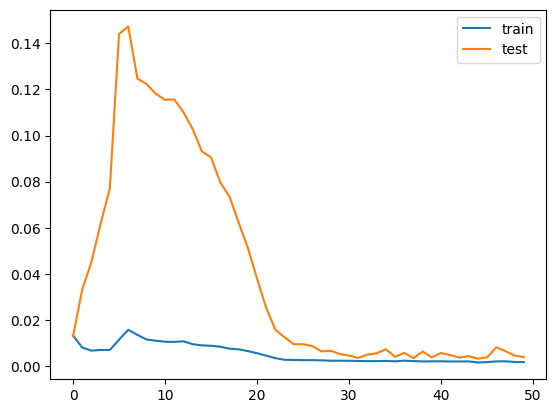

In [11]:
input_sql_file='../sql_files/test.sql'
df = generate_df_from_sql_file(input_sql_file, db)
main_build_model(df, 5)

In [11]:
df.head()

ticktype    price  volume                        timestamp
0         1  4434.75       0 2023-06-29 22:44:07.806861+00:00
1         2  4435.00       0 2023-06-29 22:44:07.818198+00:00
2         4  4435.00       0 2023-06-29 22:44:07.824383+00:00
3         5     0.00       1 2023-06-29 22:44:07.829809+00:00
4         5     0.00       1 2023-06-29 22:44:07.838547+00:00

In [14]:
def main_hp_tuning(df, look_ahead, time_steps=60):
    # Create an instance of the DataProcessor class
    df['timestamp'] = df['timestamp'].dt.tz_localize('UTC') #adding this to update to utc
    data_processor = DataProcessor(df)

    # Process the dataframe
    data_processor.process_df()

    # Normalize and shift the data
    scaler, close_scaler = data_processor.scale_shift_data(look_ahead)

    # Create the dataset
    X, y = data_processor.create_dataset(data_processor.scaled_df, time_steps, y=data_processor.shifted_df['Close'], look_ahead=look_ahead)

    # Calculate train size
    train_ratio = 0.8
    train_size = int(len(X) * train_ratio)

    # Split the data into train and test sets using numpy indexing
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    n_features = X_train.shape[2]

    # Create a ModelBuilder instance
    model_builder = ModelBuilder(n_features, time_steps)

    # Perform hyperparameter tuning
    best_hps = model_builder.perform_hyperparameter_tuning(X_train, y_train, X_test, y_test)

#     # Print the best hyperparameters
#     print(f"""
#     The hyperparameter search is complete. The optimal number of LSTM layers is {best_hps.get('num_layers')}, and the optimal number of units in each layer is {best_hps.get('units')}. The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
#     """)

    return best_hps

In [15]:
input_sql_file='../sql_files/test.sql'
df = generate_df_from_sql_file(input_sql_file, db)

best_hps = main_hp_tuning(df, 5, 60)

/ibkr/databaseClass.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


INFO:tensorflow:Reloading Tuner from random_search/stock_price_prediction/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [10]:
best_hps = model_builder.tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)

NameError: name 'model_builder' is not defined

In [21]:
best_hps.values

{'units_1': 320,
 'dropout_1': 0.0,
 'units_2': 512,
 'dropout_2': 0.0,
 'units_3': 64,
 'dropout_3': 0.30000000000000004,
 'dense_units': 32}